# Import packages

In [11]:
import numpy as np
import os
import re
import pandas as pd


import ldc.io.hdf5 as h5io
from ldc.lisa.noise import get_noise_model  
                                                                                                                                                               
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


import seaborn as sns
import matplotlib.pyplot as plt



%matplotlib inline

# Useful Definitions

In [22]:
def plot_corner(data, features, hue_col, save_path=None, palette=None):
    """
    Generates a half corner plot (pairplot) of the specified features, colored by the given hue column.
    
    Args:
      data (pd.DataFrame): DataFrame containing the data to plot.
      features (list): List of feature column names to include in the pairplot.
      hue_col (str): Column name in data to use for coloring.
      save_path (str, optional): Path to save the plot image.
      palette (dict, optional): Dictionary mapping discrete hue values to RGBA colors.
    """
    pairplot_fig = sns.pairplot(data, vars=features, hue=hue_col, diag_kind="kde", corner=True, palette=palette)
    if save_path:
        pairplot_fig.savefig(save_path)
        plt.close()
    else:
        plt.show()

def plot_corner_predicted(data, features, save_path=None, palette=None):
    return plot_corner(data, features, hue_col="Predicted_Class", save_path=save_path, palette=palette)

def plot_corner_true(data, features, save_path=None, palette=None):
    return plot_corner(data, features, hue_col="True_Class", save_path=save_path, palette=palette)

In [12]:
def extract_model_info(filename):
    """
    Extracts the model name and version from the filename.
    Example:
        'resolved_Model1_0_MW_DWDs_aa2CE_NSWDs_aa2CE_vkick.h5' -> 'Model 1.0'
        'resolved_Model1_1_MW_DWDs_aa2CE_NSWDs_aa2CE_vkick.h5' -> 'Model 1.1'
    """
    # Regular expression to capture 'Model' followed by a number, an underscore, and another number
    match = re.search(r'resolved_(Model)(\d+)_(\d+)_MW', filename)
    if match:
        model_prefix = match.group(1)      # 'Model'
        model_number = match.group(2)      # e.g., '1'
        model_version = match.group(3)     # e.g., '0', '1'
        # Format as 'Model 1.0', 'Model 1.1', etc.
        formatted_model = f"{model_prefix} {model_number}.{model_version}"
        return formatted_model
    else:
        return 'Unknown'


In [13]:
def process_h5_file(filepath):
    """
    Processes a single .h5 file and extracts the necessary parameters.
    Returns a pandas DataFrame with the extracted data and model information.
    """
    # Extract the model from the filename
    filename = os.path.basename(filepath)
    model = extract_model_info(filename)
    
    cats, units = h5io.load_array(filepath, 'cat')
    
    data = {
        'Name': cats['Name'],
        'Frequency': cats['Frequency'],
        'Amplitude': cats['Amplitude'],
        'FrequencyDerivative': cats['FrequencyDerivative'],
        'SNR': np.sqrt(cats['snr2']),
        'Eccentricity': cats['Eccentricity'],
        'Inclination': cats['Inclination'],
        'Polarization': cats['Polarization'],
        'EclipticLatitude': cats['EclipticLatitude'],
        'EclipticLongitude': cats['EclipticLongitude'],
        'InitialPhase': cats['InitialPhase'],
        'Model': model 
    }
    
    df = pd.DataFrame(data)
    
    return df

In [14]:
def compile_data_from_folder(folder_path):
    """
    Compiles data from all .h5 files in the specified folder into a single DataFrame.
    """
    all_data = []
    
    # List all .h5 files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.h5') and filename.startswith('resolved_'):
            filepath = os.path.join(folder_path, filename)
            try:
                df = process_h5_file(filepath)
                all_data.append(df)
                print(f"Processed file: {filename}")
            except Exception as e:
                print(f"Error processing file {filename}: {e}")
    
    if all_data:
        # Concatenate all DataFrames
        combined_df = pd.concat(all_data, ignore_index=True)
        return combined_df
    else:
        print("No .h5 files found or no data extracted.")
        return pd.DataFrame()  # Return empty DataFrame if no data

# Import Data

In [15]:
resolved_folder_path = '/Users/irwin/Documents/GitHub/lisa-ml/data/resolved_binaries/'
resolved_df = compile_data_from_folder(resolved_folder_path)

Processed file: resolved_Model2_1_MW_DWDs_aa2CE_NSWDs_aa2CE_vkick.h5
Processed file: resolved_Model2_2_MW_DWDs_aa2CE_NSWDs_aa2CE_akick.h5
Processed file: resolved_Model3_1_MW_DWDs_agCE_NSWDs_agCE_vkick.h5
Processed file: resolved_Model3_0_MW_DWDs_agCE.h5
Processed file: resolved_Model1_1_MW_DWDs_aaCE_NSWDs_aaCE_vkick.h5
Processed file: resolved_Model1_0_MW_DWDs_aaCE.h5
Processed file: resolved_Model1_2_MW_DWDs_aaCE_NSWDs_aaCE_akick.h5
Processed file: resolved_Model2_4_MW_DWDs_aa2CE_NSWDs_aa2CE_bkick.h5
Processed file: resolved_Model1_4_MW_DWDs_aaCE_NSWDs_aaCE_bkick.h5
Processed file: resolved_Model2_3_MW_DWDs_aa2CE_NSWDs_aa2CE_hkick.h5
Processed file: resolved_Model1_3_MW_DWDs_aaCE_NSWDs_aaCE_hkick.h5


In [16]:
resolved_df['Class'] = resolved_df['Name'].str.extract(r'MW_(DWD|NSWD)')

In [17]:
resolved_df

,Name,Frequency,Amplitude,FrequencyDerivative,SNR,Eccentricity,Inclination,Polarization,EclipticLatitude,EclipticLongitude,InitialPhase,Model,Class
0,MW_DWD 0,0.005831,4.048406e-23,9.182991e-16,40.929675,0.000000,1.439760,0.188781,-0.358973,-1.796378,1.743567,Model 2.1,DWD
1,MW_DWD 305,0.001033,7.381136e-23,1.027513e-18,12.663876,0.000000,2.174727,5.567065,-0.048659,2.669358,0.614617,Model 2.1,DWD
2,MW_DWD 336,0.001394,1.643682e-23,3.087848e-18,7.494779,0.000000,0.396333,5.029394,-0.630509,-1.943069,1.035197,Model 2.1,DWD
3,MW_DWD 343,0.001563,2.131414e-23,4.695213e-18,12.629021,0.000000,0.355345,0.959902,-0.428815,-1.823988,1.642656,Model 2.1,DWD
4,MW_DWD 345,0.001615,1.544880e-23,5.291973e-18,9.684461,0.000000,0.416277,6.137735,-0.097106,-1.674099,0.222782,Model 2.1,DWD
...,...,...,...,...,...,...,...,...,...,...,...,...,...
168721,MW_NSWD_ecc1 36818,0.001845,1.632635e-23,1.162806e-17,14.337639,0.858406,0.077106,0.315960,-0.131181,-1.551163,3.953830,Model 1.3,NSWD
168722,MW_NSWD_ecc1 46118,0.002232,9.681620e-24,3.076622e-17,9.564295,0.615259,2.509883,5.096369,-0.483056,-2.345533,2.725020,Model 1.3,NSWD
168723,MW_NSWD_ecc1 52477,0.002261,8.940144e-24,1.777973e-17,9.630959,0.781611,2.581236,1.463049,-0.155964,-1.767237,6.199689,Model 1.3,NSWD
168724,MW_NSWD_ecc1 52477,0.002363,8.250590e-24,1.858790e-17,9.557340,0.781611,2.581236,1.463049,-0.155964,-1.767237,6.199689,Model 1.3,NSWD


In [18]:
selected_features = ['Frequency', 'Amplitude', 'FrequencyDerivative', 'SNR', 'Eccentricity']

resolved_df = resolved_df.dropna(subset=selected_features + ['Class'])

# Encode labels: DWD=0, NSWD=1
label_encoder = LabelEncoder()
resolved_df['Class'] = label_encoder.fit_transform(resolved_df['Class'])


In [19]:
resolved_df

,Name,Frequency,Amplitude,FrequencyDerivative,SNR,Eccentricity,Inclination,Polarization,EclipticLatitude,EclipticLongitude,InitialPhase,Model,Class
0,MW_DWD 0,0.005831,4.048406e-23,9.182991e-16,40.929675,0.000000,1.439760,0.188781,-0.358973,-1.796378,1.743567,Model 2.1,0
1,MW_DWD 305,0.001033,7.381136e-23,1.027513e-18,12.663876,0.000000,2.174727,5.567065,-0.048659,2.669358,0.614617,Model 2.1,0
2,MW_DWD 336,0.001394,1.643682e-23,3.087848e-18,7.494779,0.000000,0.396333,5.029394,-0.630509,-1.943069,1.035197,Model 2.1,0
3,MW_DWD 343,0.001563,2.131414e-23,4.695213e-18,12.629021,0.000000,0.355345,0.959902,-0.428815,-1.823988,1.642656,Model 2.1,0
4,MW_DWD 345,0.001615,1.544880e-23,5.291973e-18,9.684461,0.000000,0.416277,6.137735,-0.097106,-1.674099,0.222782,Model 2.1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
168721,MW_NSWD_ecc1 36818,0.001845,1.632635e-23,1.162806e-17,14.337639,0.858406,0.077106,0.315960,-0.131181,-1.551163,3.953830,Model 1.3,1
168722,MW_NSWD_ecc1 46118,0.002232,9.681620e-24,3.076622e-17,9.564295,0.615259,2.509883,5.096369,-0.483056,-2.345533,2.725020,Model 1.3,1
168723,MW_NSWD_ecc1 52477,0.002261,8.940144e-24,1.777973e-17,9.630959,0.781611,2.581236,1.463049,-0.155964,-1.767237,6.199689,Model 1.3,1
168724,MW_NSWD_ecc1 52477,0.002363,8.250590e-24,1.858790e-17,9.557340,0.781611,2.581236,1.463049,-0.155964,-1.767237,6.199689,Model 1.3,1


In [11]:
df = resolved_df

# Building Neural Network

In [51]:
inconsistent_rows = df[(df['Eccentricity'] == 0) & (df['Class'] == 0)]
inconsistent_rows

,Name,Frequency,Amplitude,FrequencyDerivative,SNR,Eccentricity,Inclination,Polarization,EclipticLatitude,EclipticLongitude,InitialPhase,Model,Class


In [18]:
# Drop columns that are not used as features.
# Here we drop 'Model' and 'Name', using 'Class' as our target.
X = df.drop(['Model', 'Name', 'Class'], axis=1)
y = df['Class']


# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)  # Make it (n,1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [22]:
# Define the neural network model
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()  # Sigmoid activation for binary classification
        )
    
    def forward(self, x):
        return self.model(x)

input_dim = X_train_tensor.shape[1]
model = BinaryClassifier(input_dim)

# Define the loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [25]:
# Training loop
num_epochs = 100
train_loss_history = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    train_loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

Epoch 1, Loss: 0.0110
Epoch 2, Loss: 0.0111
Epoch 3, Loss: 0.0107
Epoch 4, Loss: 0.0107
Epoch 5, Loss: 0.0105
Epoch 6, Loss: 0.0103
Epoch 7, Loss: 0.0102
Epoch 8, Loss: 0.0100
Epoch 9, Loss: 0.0101
Epoch 10, Loss: 0.0100
Epoch 11, Loss: 0.0098
Epoch 12, Loss: 0.0100
Epoch 13, Loss: 0.0097
Epoch 14, Loss: 0.0097
Epoch 15, Loss: 0.0096
Epoch 16, Loss: 0.0094
Epoch 17, Loss: 0.0094
Epoch 18, Loss: 0.0094
Epoch 19, Loss: 0.0094
Epoch 20, Loss: 0.0092
Epoch 21, Loss: 0.0093
Epoch 22, Loss: 0.0094
Epoch 23, Loss: 0.0090
Epoch 24, Loss: 0.0092
Epoch 25, Loss: 0.0092
Epoch 26, Loss: 0.0089
Epoch 27, Loss: 0.0090
Epoch 28, Loss: 0.0090
Epoch 29, Loss: 0.0088
Epoch 30, Loss: 0.0090
Epoch 31, Loss: 0.0089
Epoch 32, Loss: 0.0094
Epoch 33, Loss: 0.0086
Epoch 34, Loss: 0.0094
Epoch 35, Loss: 0.0094
Epoch 36, Loss: 0.0085
Epoch 37, Loss: 0.0092
Epoch 38, Loss: 0.0097
Epoch 39, Loss: 0.0090
Epoch 40, Loss: 0.0092
Epoch 41, Loss: 0.0092
Epoch 42, Loss: 0.0127
Epoch 43, Loss: 0.0091
Epoch 44, Loss: 0.00

In [28]:
# Evaluate the model on the test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        # Convert outputs to binary predictions
        predicted = (outputs >= 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print("Test Accuracy: {:.2f}%".format(accuracy * 100))

Test Accuracy: 99.78%


# Evaluation and Plots

## Loss

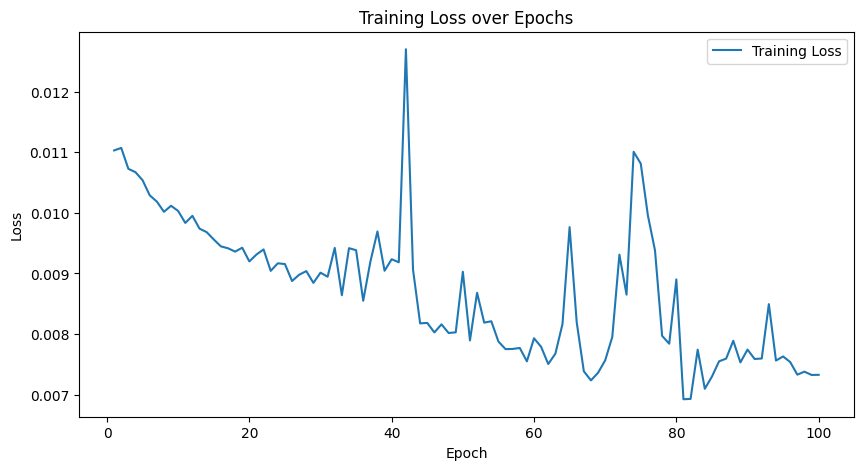

In [31]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()
plt.show()

## SE SP

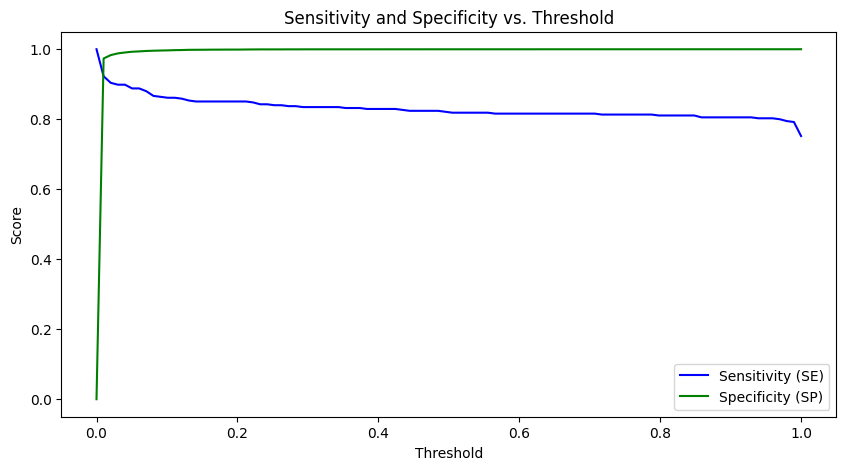

In [32]:
model.eval()
with torch.no_grad():
    # Get outputs; squeeze to remove extra dimensions if necessary.
    outputs = model(X_test_tensor).squeeze().numpy()

# True labels from the test set.
true_labels = y_test_tensor.squeeze().numpy()

# Define a range of thresholds.
thresholds = np.linspace(0, 1, 100)
sensitivity = []
specificity = []

# For each threshold, compute sensitivity (SE) and specificity (SP).
for t in thresholds:
    # Binarize predictions using the current threshold.
    preds = (outputs >= t).astype(int)
    
    # Calculate components of the confusion matrix.
    TP = np.sum((preds == 1) & (true_labels == 1))
    TN = np.sum((preds == 0) & (true_labels == 0))
    FP = np.sum((preds == 1) & (true_labels == 0))
    FN = np.sum((preds == 0) & (true_labels == 1))
    
    # Compute sensitivity and specificity.
    se = TP / (TP + FN) if (TP + FN) > 0 else 0
    sp = TN / (TN + FP) if (TN + FP) > 0 else 0
    sensitivity.append(se)
    specificity.append(sp)

plt.figure(figsize=(10, 5))
plt.plot(thresholds, sensitivity, label="Sensitivity (SE)", color="blue")
plt.plot(thresholds, specificity, label="Specificity (SP)", color="green")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Sensitivity and Specificity vs. Threshold")
plt.legend()
plt.show()

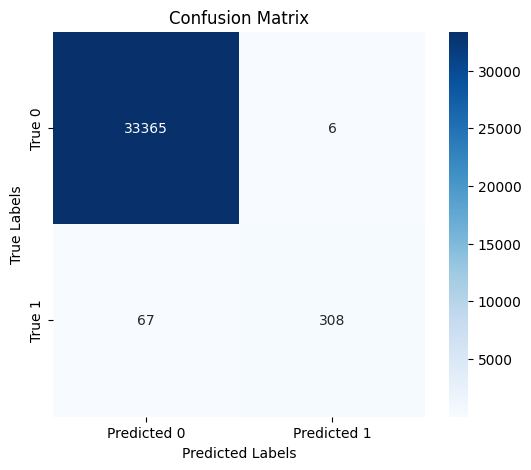

In [40]:

model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor).squeeze().numpy()
    

true_labels = y_test_tensor.squeeze().numpy()
predicted_labels = (outputs >= 0.5).astype(int)

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Histogram of Probabilities

In [35]:
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor).squeeze().numpy() 

true_labels = y_test_tensor.squeeze().numpy()

class0_indices = (true_labels == 0)
class1_indices = (true_labels == 1)
predictions_class0 = outputs[class0_indices]
predictions_class1 = outputs[class1_indices]


/var/folders/rm/5j_dp79x6xx6xmxlxxs9k4y80000gn/T/ipykernel_63929/925499820.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


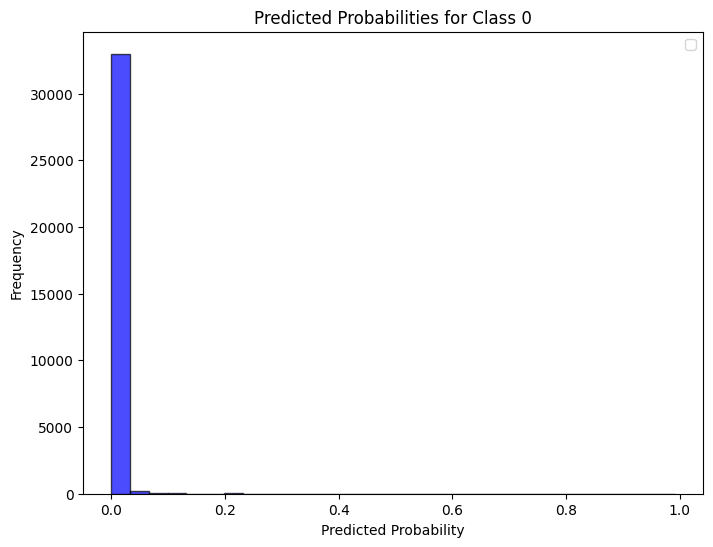

In [37]:
plt.figure(figsize=(8, 6))
plt.hist(predictions_class0, bins=30, color='blue', alpha=0.7, edgecolor='black')
#plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold = 0.5')
plt.title('Predicted Probabilities for Class 0')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend()
plt.show()

/var/folders/rm/5j_dp79x6xx6xmxlxxs9k4y80000gn/T/ipykernel_63929/2276595417.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


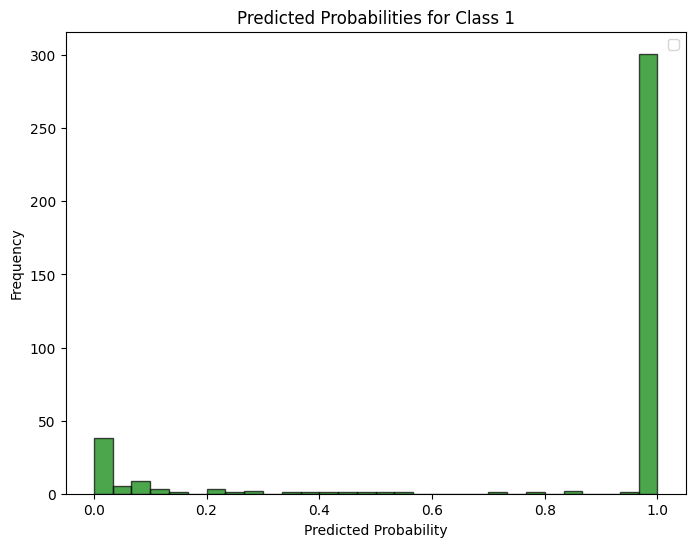

In [38]:
# Plot figure for class 1
plt.figure(figsize=(8, 6))
plt.hist(predictions_class1, bins=30, color='green', alpha=0.7, edgecolor='black')
plt.title('Predicted Probabilities for Class 1')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [45]:
predicted_labels = (outputs >= 0.5).astype(int) #threshold 0.5

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
# The confusion matrix is organized as:
#         Predicted: 0     Predicted: 1
# True: 0      TN                FP
# True: 1      FN                TP
TN, FP, FN, TP = cm.ravel()

sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
accuracy    = (TP + TN) / (TP + TN + FP + FN)

metrics_df = pd.DataFrame({
    'Metric': ['Sensitivity (SE)', 'Specificity (SP)', 'Accuracy'],
    'Value': [sensitivity, specificity, accuracy]
})
metrics_df


,Metric,Value
0,Sensitivity (SE),0.821333
1,Specificity (SP),0.999820
2,Accuracy,0.997837


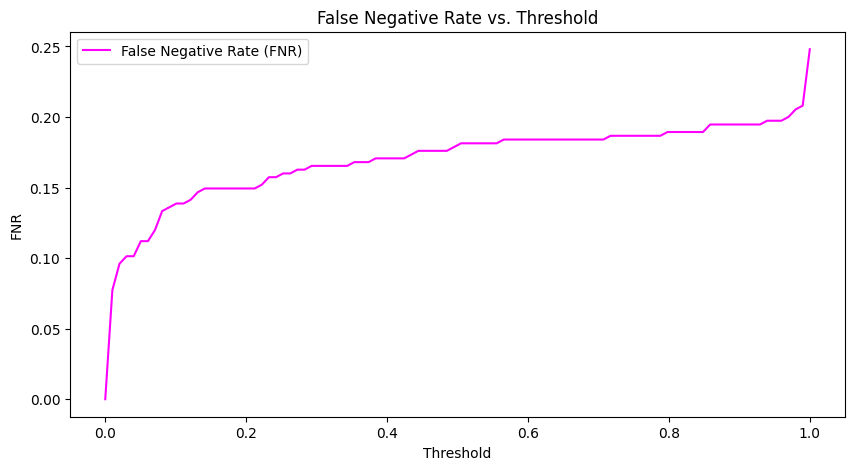

In [47]:
true_labels = y_test_tensor.squeeze().numpy()


thresholds = np.linspace(0, 1, 100)
fnr_list = []

for t in thresholds:

    preds = (outputs >= t).astype(int)
    
    TP = np.sum((preds == 1) & (true_labels == 1))
    FN = np.sum((preds == 0) & (true_labels == 1))
    
    fnr = FN / (TP + FN) if (TP + FN) > 0 else 0
    fnr_list.append(fnr)


plt.figure(figsize=(10, 5))
plt.plot(thresholds, fnr_list, label="False Negative Rate (FNR)", color="magenta")
plt.xlabel("Threshold")
plt.ylabel("FNR")
plt.title("False Negative Rate vs. Threshold")
plt.legend()
plt.show()

# KNN Results to compare with

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


In [26]:
features = [
    'Frequency', 'Amplitude', 'FrequencyDerivative', 'SNR', 'Eccentricity'
   ]
X = resolved_df[features]


y = resolved_df['Class']

le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("\nClasses:", le.classes_)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=1
)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

k_values = range(1, 100) 
accuracies = []
f1_scores = [] 

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracies.append(acc)
    f1_scores.append(f1)



Classes: ['DWD' 'NSWD']


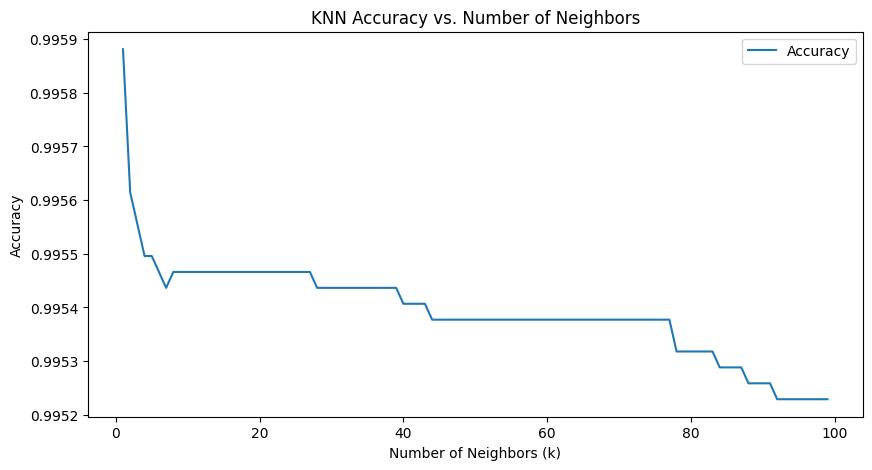

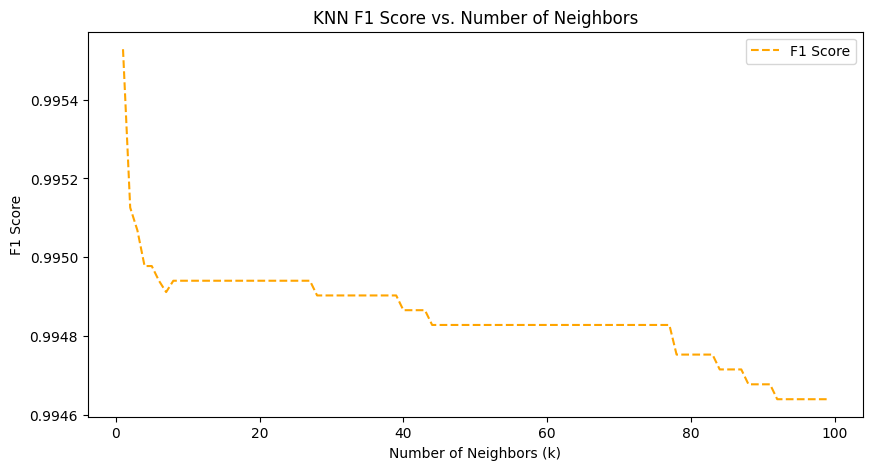

In [30]:

plt.figure(figsize=(10, 5))
plt.plot(k_values, accuracies, linestyle='-', label='Accuracy')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.title("KNN Accuracy vs. Number of Neighbors")
#plt.xticks(k_values)
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(k_values, f1_scores, color='orange', linestyle='--', label='F1 Score')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("F1 Score")
plt.title("KNN F1 Score vs. Number of Neighbors")
#plt.xticks(k_values)
plt.legend()
plt.show()


Classes: ['DWD' 'NSWD']


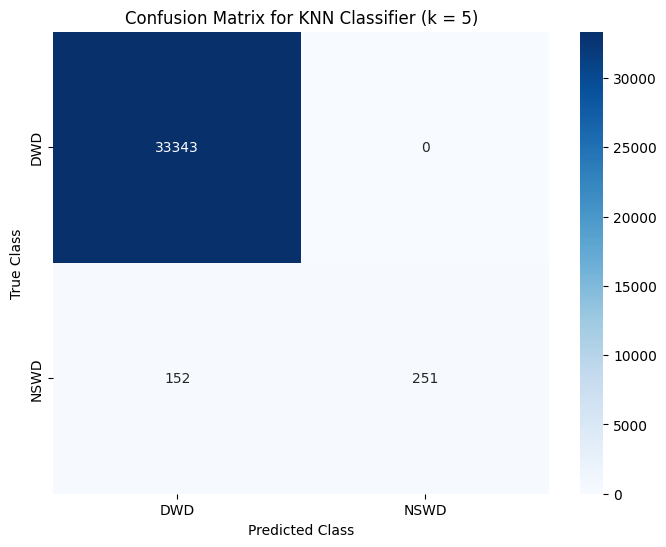

In [40]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier


features = ['Frequency', 'Amplitude', 'FrequencyDerivative', 'SNR', 'Eccentricity']

X = resolved_df[features]
y = resolved_df['Class']
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("\nClasses:", le.classes_)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=1
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

k = 5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)


df_test = pd.DataFrame(X_test, columns=features)

df_test['True_Class'] = le.inverse_transform(y_test)
df_test['Predicted_Class'] = le.inverse_transform(y_pred)


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title(f'Confusion Matrix for KNN Classifier (k = {k})')
plt.show()

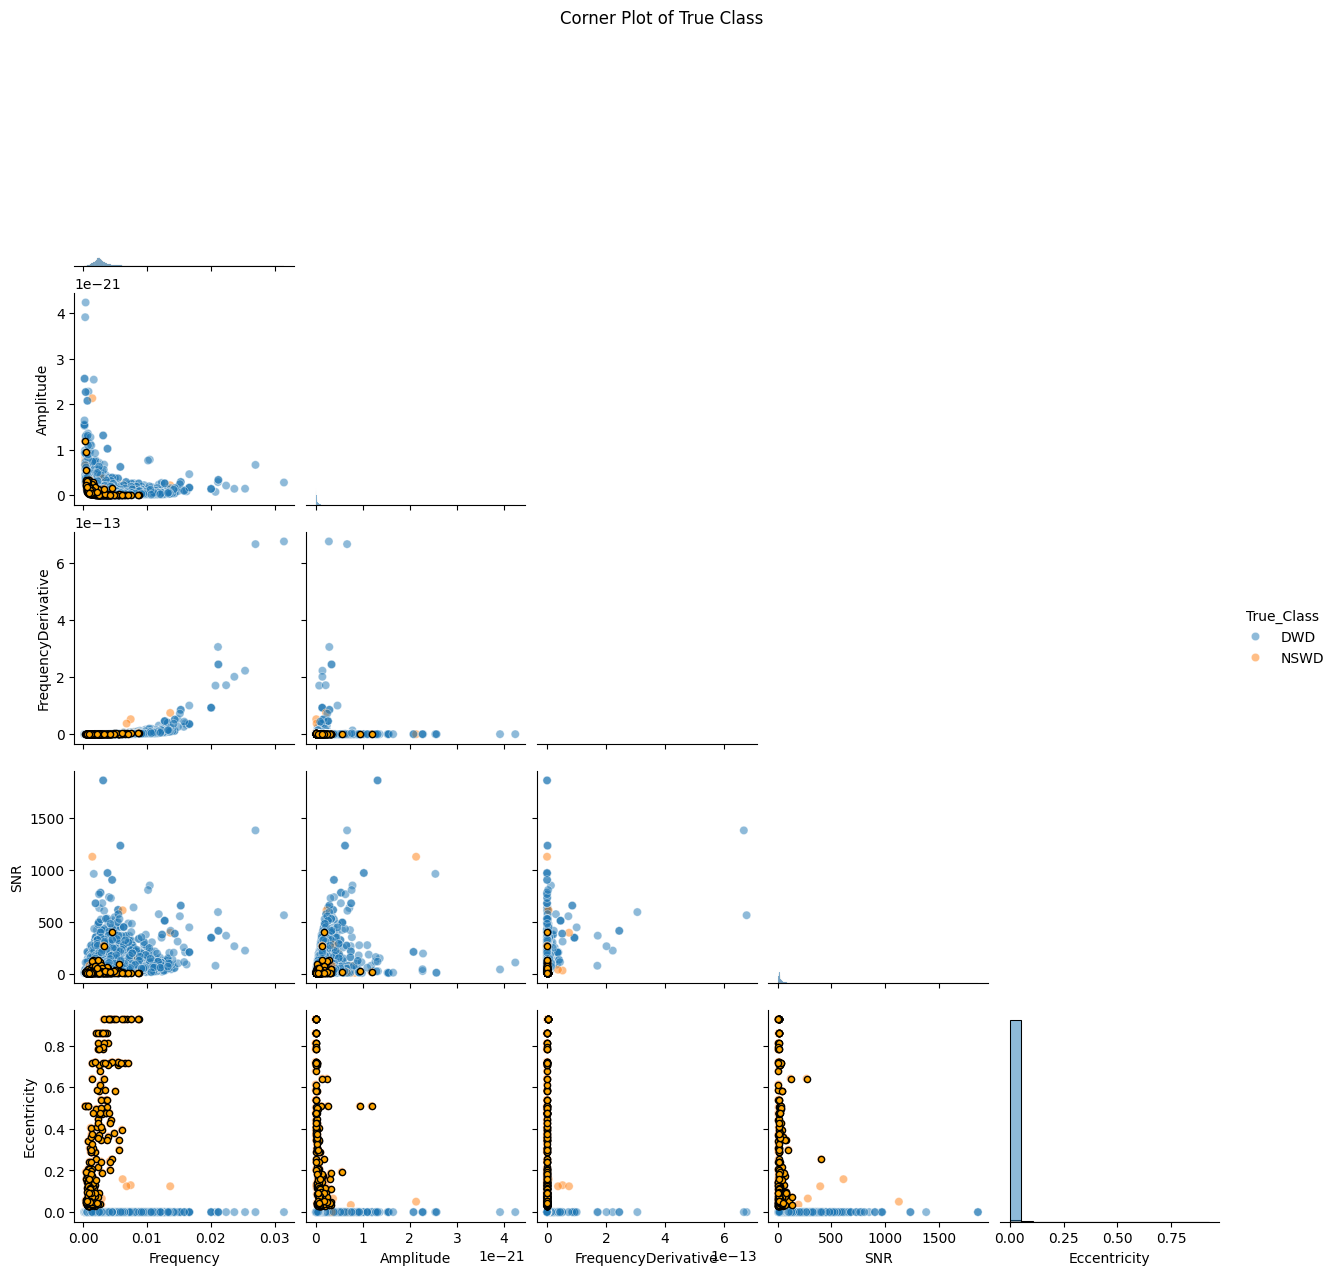

In [39]:
g = sns.pairplot(df_test, vars=features, hue='True_Class', diag_kind='hist',
                 corner=True, plot_kws={'alpha': 0.5})

minority_class = 'NSWD'
minority_df = df_test[df_test['Predicted_Class'] == minority_class]


for i, j in zip(*np.tril_indices_from(g.axes, -1)):
    ax = g.axes[i, j]
    x_var = features[j]
    y_var = features[i]
    ax.scatter(minority_df[x_var], minority_df[y_var],
               color='orange',  # Use a color that stands out.
               alpha=1,         # Fully opaque.
               edgecolor='k',
               s=20)           # Adjust point size if needed.

plt.suptitle(f"Corner Plot of True Class", y=1.02)
plt.show()

More meaningful to run the classifier without the ecc parameter. 

# No Ecc

In [32]:
features = [
    'Frequency', 'Amplitude', 'FrequencyDerivative', 'SNR'
   ]
X = resolved_df[features]


y = resolved_df['Class']

le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("\nClasses:", le.classes_)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=1
)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

k_values = range(1, 100) 
accuracies = []
f1_scores = [] 

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracies.append(acc)
    f1_scores.append(f1)



Classes: ['DWD' 'NSWD']


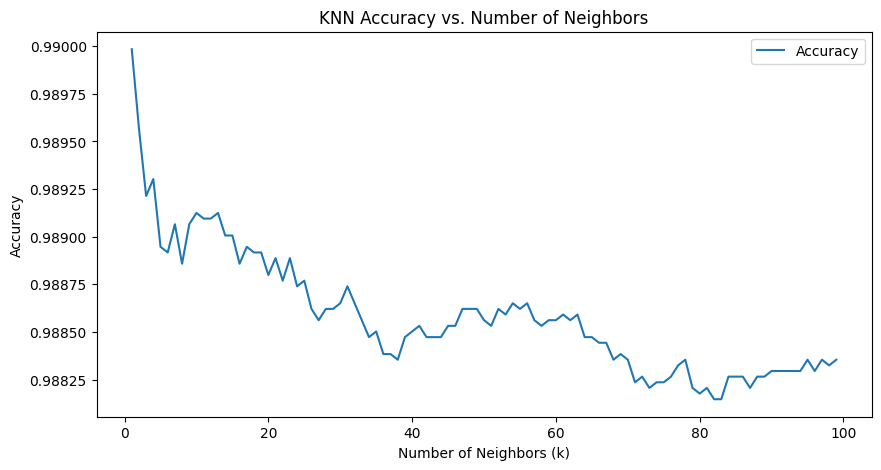

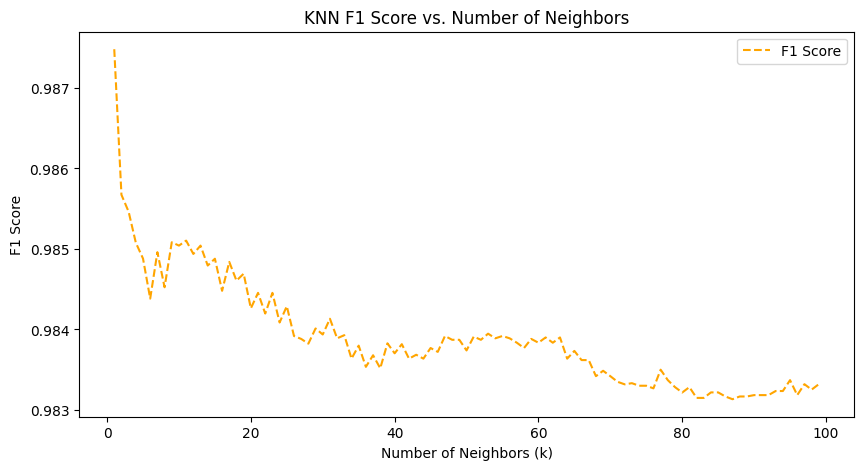

In [33]:

plt.figure(figsize=(10, 5))
plt.plot(k_values, accuracies, linestyle='-', label='Accuracy')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.title("KNN Accuracy vs. Number of Neighbors")
#plt.xticks(k_values)
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(k_values, f1_scores, color='orange', linestyle='--', label='F1 Score')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("F1 Score")
plt.title("KNN F1 Score vs. Number of Neighbors")
#plt.xticks(k_values)
plt.legend()
plt.show()


Classes: ['DWD' 'NSWD']


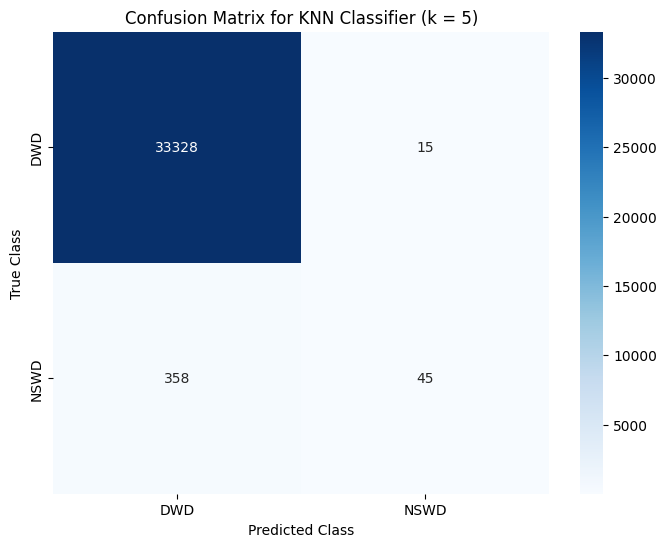

In [41]:
features = ['Frequency', 'Amplitude', 'FrequencyDerivative', 'SNR']

X = resolved_df[features]
y = resolved_df['Class']
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("\nClasses:", le.classes_)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=1
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

k = 5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)


df_test = pd.DataFrame(X_test, columns=features)

df_test['True_Class'] = le.inverse_transform(y_test)
df_test['Predicted_Class'] = le.inverse_transform(y_pred)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title(f'Confusion Matrix for KNN Classifier (k = {k})')
plt.show()

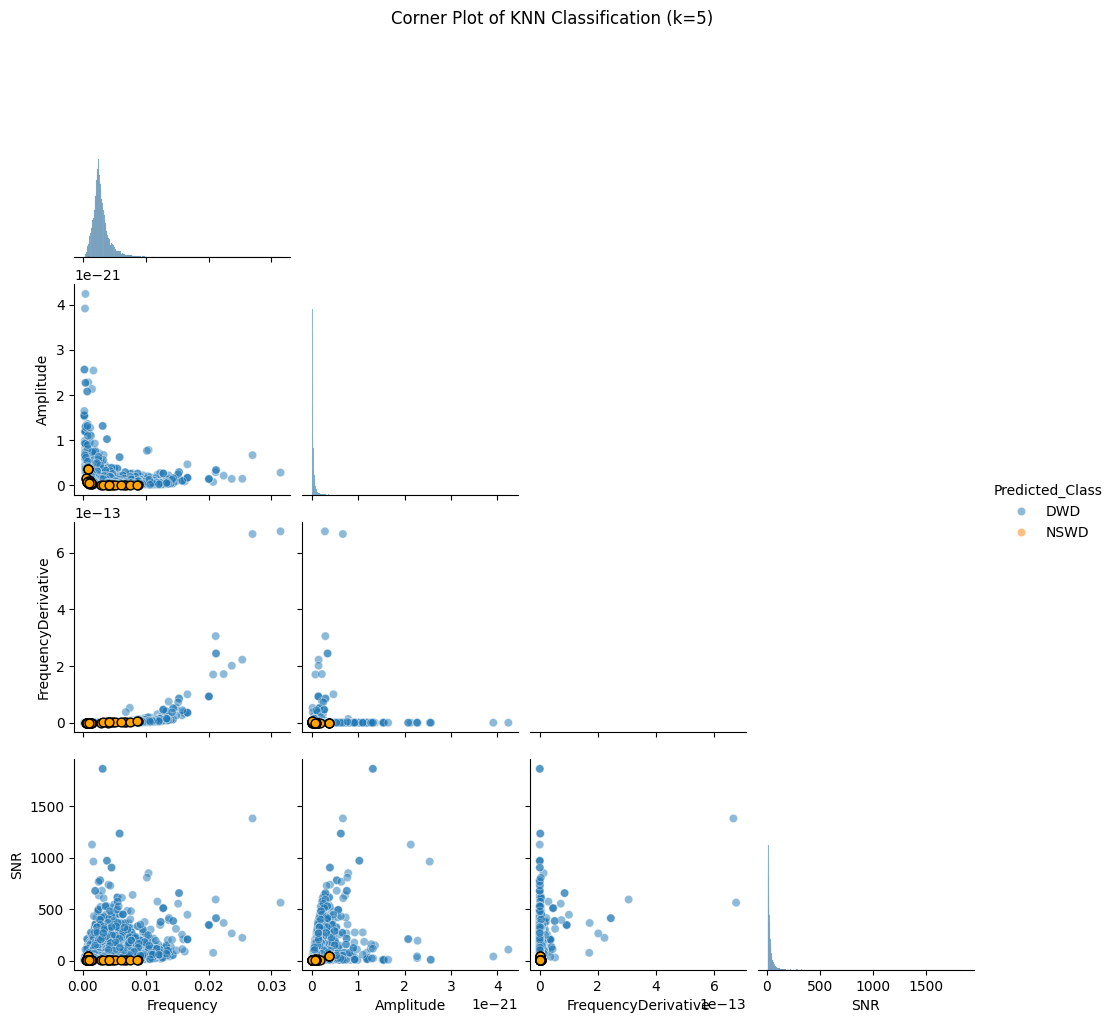

In [36]:
g = sns.pairplot(df_test, vars=features, hue='Predicted_Class', diag_kind='hist',
                 corner=True, plot_kws={'alpha': 0.5})

minority_class = 'NSWD'
minority_df = df_test[df_test['Predicted_Class'] == minority_class]


for i, j in zip(*np.tril_indices_from(g.axes, -1)):
    ax = g.axes[i, j]
    x_var = features[j]
    y_var = features[i]
    ax.scatter(minority_df[x_var], minority_df[y_var],
               color='orange',  # Use a color that stands out.
               alpha=1,         # Fully opaque.
               edgecolor='k',
               s=40)           # Adjust point size if needed.

plt.suptitle(f"Corner Plot of KNN Classification (k=5)", y=1.02)
plt.show()

KNN Compared with Baseline_log

In [20]:
resolved_df['Frequency_mHz'] = resolved_df['Frequency'] * 1000
resolved_df['FrequencyDerivative_log10'] = np.log10(resolved_df['FrequencyDerivative'])
resolved_df['EclipticLatitude_sin'] = np.sin(resolved_df['EclipticLatitude'])
resolved_df['Amplitude_log10'] = np.log10(resolved_df['Amplitude'])
resolved_df['Inclination_cos'] = np.cos(resolved_df['Inclination'])

cols_to_remove = ['Frequency', 'FrequencyDerivative', 'EclipticLatitude', 'Amplitude', 'Inclination']
resolved_df.drop(columns=cols_to_remove, inplace=True)


Classes: [0 1]


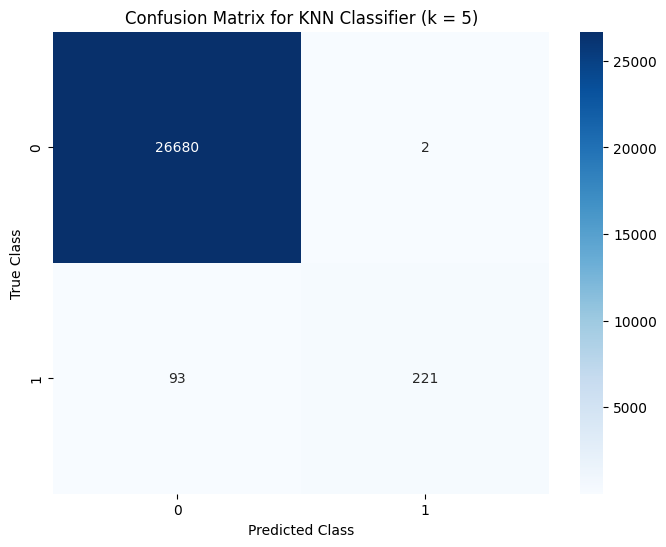

In [35]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier


features = ['Frequency_mHz', 'Amplitude_log10', 'FrequencyDerivative_log10', 'SNR', 'Eccentricity']

X = resolved_df[features]
y = resolved_df['Class']
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("\nClasses:", le.classes_)

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=1
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=1
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

k = 5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_val_scaled)


df_test = pd.DataFrame(X_val, columns=features)

df_test['True_Class'] = le.inverse_transform(y_val)
df_test['Predicted_Class'] = le.inverse_transform(y_pred)
df_test['Prediction_Status'] = np.where(df_test['True_Class'] == df_test['Predicted_Class'], 'Correct', 'Wrong')

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title(f'Confusion Matrix for KNN Classifier (k = {k})')
plt.show()

In [32]:
df_test

,Frequency_mHz,Amplitude_log10,FrequencyDerivative_log10,SNR,Eccentricity,True_Class,Predicted_Class,Prediction_Status
123236,3.484907,-22.438569,-15.913885,32.716829,0.000000,0,0,Correct
102027,1.066587,-22.158185,-17.966193,17.955934,0.000000,0,0,Correct
110138,2.050923,-22.729096,-16.602812,17.578497,0.000000,0,0,Correct
156703,3.571540,-22.449438,-15.867372,31.363810,0.000000,0,0,Correct
164847,4.441413,-23.138072,-16.074490,7.619640,0.440813,1,1,Correct
...,...,...,...,...,...,...,...,...
162680,2.484997,-22.555296,-16.385252,15.194529,0.000000,0,0,Correct
83167,1.868353,-22.212078,-17.231444,29.771517,0.000000,0,0,Correct
128005,1.555143,-22.460326,-16.819814,19.310299,0.000000,0,0,Correct
142666,2.582640,-22.774683,-16.646118,9.302695,0.000000,0,0,Correct


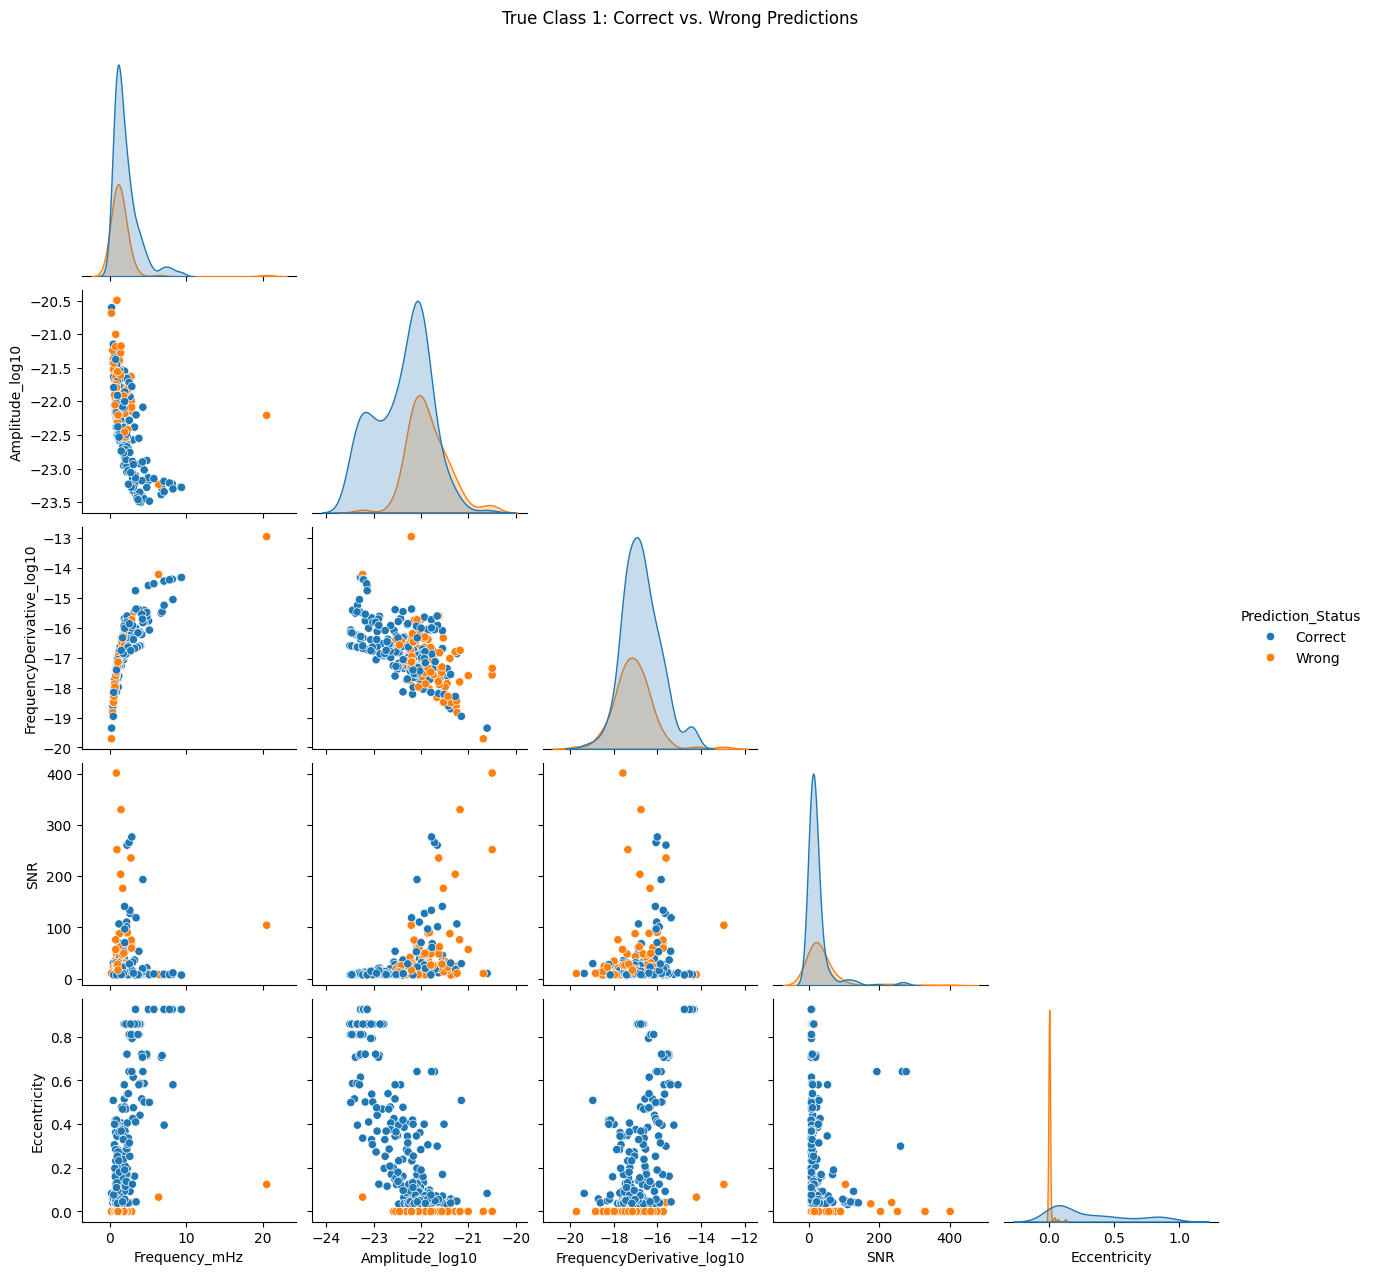

In [36]:
df_class1 = df_test[df_test['True_Class'] == 1]
pairplot_class1 = sns.pairplot(df_class1, vars=features, hue='Prediction_Status', diag_kind="kde", corner=True)
pairplot_class1.fig.suptitle("True Class 1: Correct vs. Wrong Predictions", y=1.02)
plt.show()

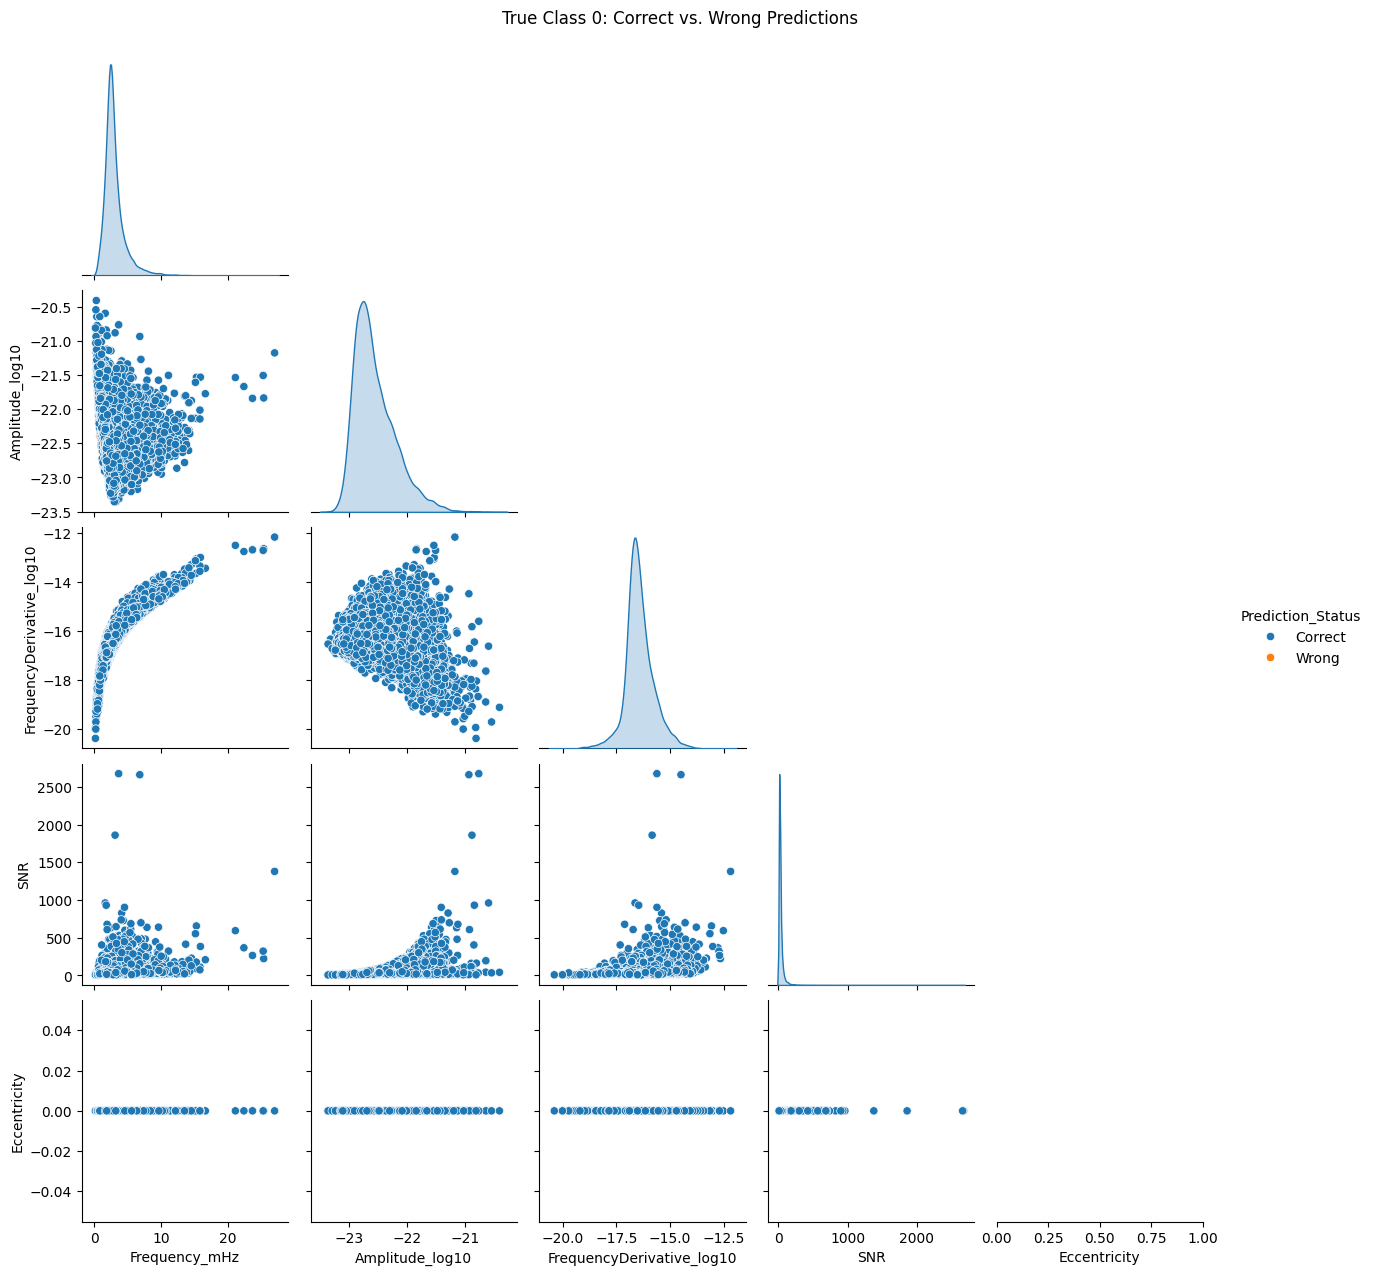

In [37]:
df_class0 = df_test[df_test['True_Class'] == 0]
pairplot_class0 = sns.pairplot(df_class0, vars=features, hue='Prediction_Status', diag_kind="kde", corner=True)
pairplot_class0.fig.suptitle("True Class 0: Correct vs. Wrong Predictions", y=1.02)
plt.show()